# Install the required libraries

In [ ]:
!pip install azureml-core
!pip install mltable

In [ ]:
!pip install azure-ai-ml

In [ ]:
# Azure ML libraries
from azureml.core import Experiment, Workspace, Dataset, Datastore
import azureml

# Check core SDK version number
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK.\n")

# Load workspace into variable
ws = Workspace.from_config()
print('Workspace name: ' + ws.name,
      'Azure region: ' + ws.location,
      'Subscription id: ' + ws.subscription_id,
      'Resource group: ' + ws.resource_group, sep='\n')

# Create an Azure ML experiment in the workspace
#experiment = Experiment(workspace = ws, name = "customer-churn-EDA-experiment")
experiment_name = "customer_churn_experiment"

You are currently using version 1.51.0 of the Azure ML SDK.

Workspace name: churnmlworkspace
Azure region: eastus2
Subscription id: 933f01f3-4472-472f-b871-6d951277b79a
Resource group: azurecustomerchurn


In [ ]:
# Start logging data in the experiment
run = experiment.start_logging()
print("Starting experiment:", experiment.name)

Starting experiment: customer-churn-EDA-experiment


In [ ]:
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
mlflow.set_experiment(experiment_name)
mlflow.autolog()

2024/03/23 10:57:55 INFO mlflow.tracking.fluent: Experiment with name 'customer_churn_experiment' does not exist. Creating a new experiment.
2024/03/23 10:57:56 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2024/03/23 10:57:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/03/23 10:57:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/23 10:57:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


# Import the required libraries

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import mlflow

# Import and explore the dataset

In [ ]:
ws.datasets

{'customerchurn': DatasetRegistration(id='2df6c811-57c4-4023-ac1a-1e48e1d1ada4', name='customerchurn', version=1, description='', tags={})}

In [ ]:
import mltable
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

ml_client = MLClient.from_config(credential=DefaultAzureCredential())
data_asset = ml_client.data.get("customerchurn", version="1")

tbl = mltable.load(f'azureml:/{data_asset.id}')

df = tbl.to_pandas_dataframe()
df

Found the config file in: /config.json


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,74.40,306.6,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerID       7043 non-null   object 
 1   gender           7043 non-null   object 
 2   SeniorCitizen    7043 non-null   int64  
 3   Partner          7043 non-null   object 
 4   Dependents       7043 non-null   object 
 5   tenure           7043 non-null   int64  
 6   PhoneService     7043 non-null   object 
 7   MultipleLines    7043 non-null   object 
 8   InternetService  7043 non-null   object 
 9   MonthlyCharges   7043 non-null   float64
 10  TotalCharges     7043 non-null   object 
 11  Churn            7043 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 660.4+ KB


In [ ]:
df.dtypes

customerID          object
gender              object
SeniorCitizen        int64
Partner             object
Dependents          object
tenure               int64
PhoneService        object
MultipleLines       object
InternetService     object
MonthlyCharges     float64
TotalCharges        object
Churn               object
dtype: object

From observation, we can see that the customerID column isn't useful for us, hence we drop it

In [ ]:
df.drop('customerID',axis='columns',inplace=True)

Exploring the **gender** column

In [ ]:
df['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

Since **gender** is a categorical value, we decide to replace it with labels for the categories instead of strings

In [ ]:
# Replace values for the gender column
df['gender'].replace({'Female':1,'Male':0},inplace=True)

Exploring and altering the **SeniorCitizen** column

In [ ]:
df['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Since its already in the correct format, we don't need to change it

Exploring and altering the **Partner** column

In [ ]:
df['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

In [ ]:
df["Partner"].replace({"Yes":1,"No":0},inplace=True)

Exploring and altering the **Dependents** column

In [ ]:
df['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

In [ ]:
df["Dependents"].replace({"Yes":1,"No":0},inplace=True)

Exploring the **PhoneService** column

In [ ]:
df['PhoneService'].value_counts()

Yes    6361
No      682
Name: PhoneService, dtype: int64

In [ ]:
df["PhoneService"].replace({"Yes":1,"No":0},inplace=True)

Exploring the **InternetService** column

In [ ]:
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

In [ ]:
df['InternetService'] = df['InternetService'].map({'DSL': 2, 'Fiber optic': 1, 'No': 0})

Exploring the **MultipleLines** column

In [ ]:
df['MultipleLines'].value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

In [ ]:
#Since No phone Service and No are the same thing
mapping_dict = {'No phone service': 0, 'No': 0, 'Yes': 1}

df['MultipleLines'] = df['MultipleLines'].map(mapping_dict)

Converting the data type of the **TotalCharges** column to float, handling the errors and missing values

In [ ]:
# Convert total charges to float type
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

In [ ]:
df["TotalCharges"] = df["TotalCharges"].replace(np.nan, 0)

Replacing values for the **Churn** column

In [ ]:
# Replace values for Churn column
df["Churn"].replace({"Yes":1,"No":0},inplace=True)

# Outlier Analysis

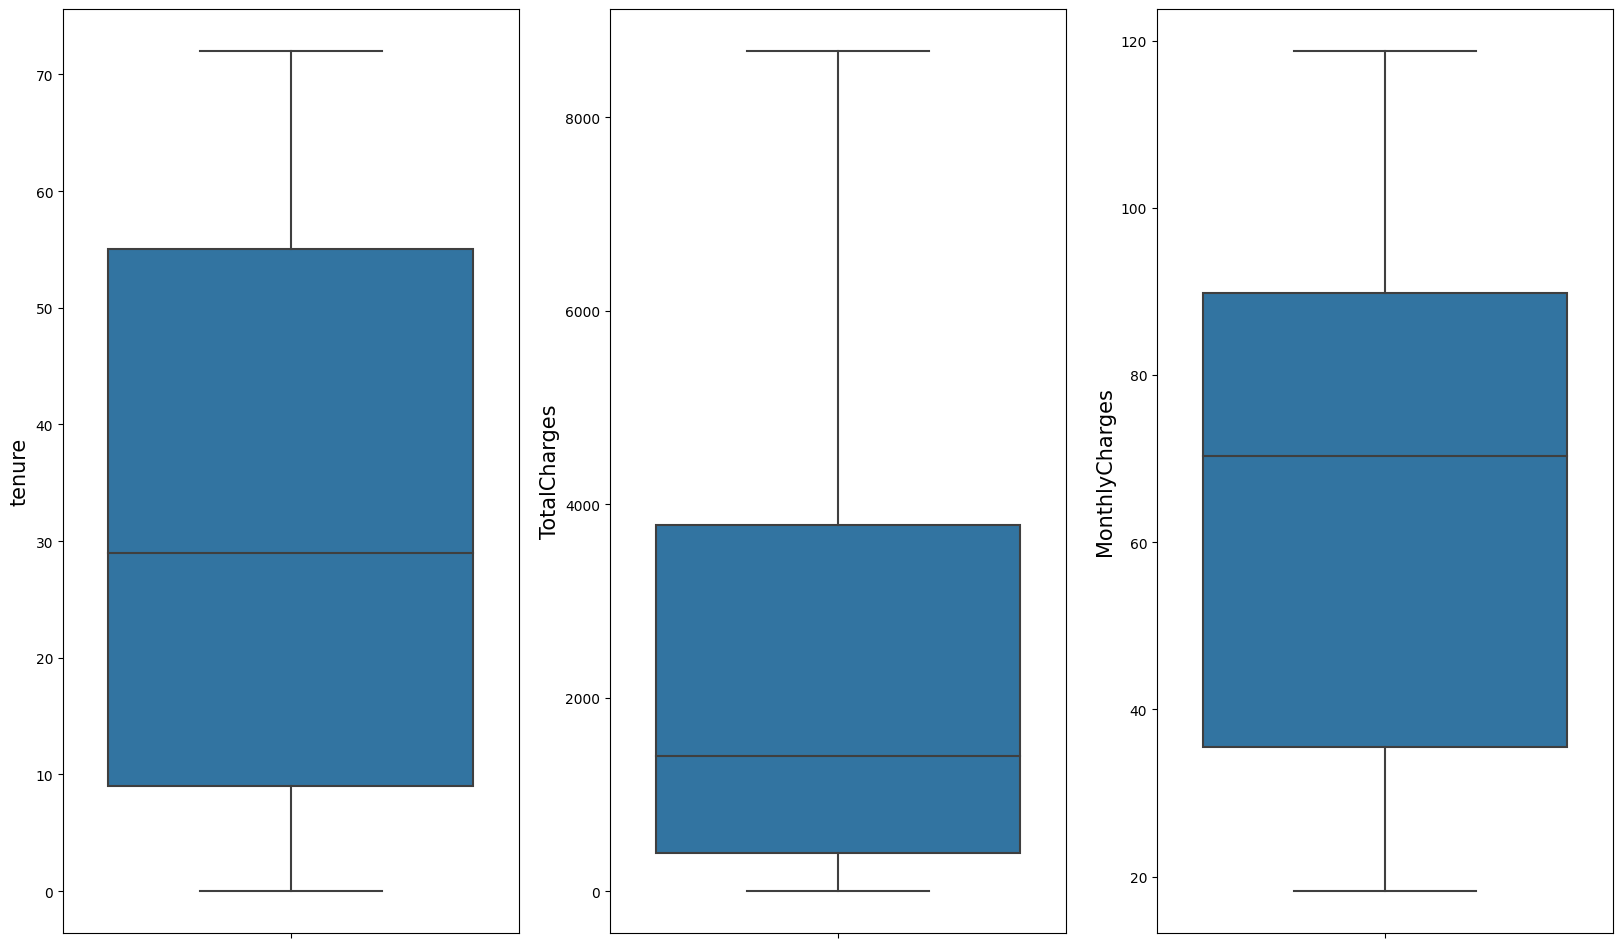

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 12))

cols = ["tenure", "TotalCharges", "MonthlyCharges"]

for i in range(3):
    sns.boxplot(data=df, y=cols[i], ax=axes[i]);
    axes[i].yaxis.label.set_size(15)

Here, we can see there are no outliers

# MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']
scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [ ]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,0.013889,0,0,2,0.115423,0.003437,0
1,0,0,0,0,0.472222,1,0,2,0.385075,0.217564,0
2,0,0,0,0,0.027778,1,0,2,0.354229,0.012453,1
3,0,0,0,0,0.625000,0,0,2,0.239303,0.211951,0
4,1,0,0,0,0.027778,1,0,1,0.521891,0.017462,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           7043 non-null   int64  
 1   SeniorCitizen    7043 non-null   int64  
 2   Partner          7043 non-null   int64  
 3   Dependents       7043 non-null   int64  
 4   tenure           7043 non-null   float64
 5   PhoneService     7043 non-null   int64  
 6   MultipleLines    7043 non-null   int64  
 7   InternetService  7043 non-null   int64  
 8   MonthlyCharges   7043 non-null   float64
 9   TotalCharges     7043 non-null   float64
 10  Churn            7043 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 605.4 KB


# Split data into train and test

In [ ]:
X = df.drop(columns = ['Churn']) # independent valriables
y = df['Churn'].values # target

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

# GridSearchCV (Hyperparmater Tuning)

In [ ]:
from sklearn.model_selection import GridSearchCV
## Hyperparmater Tuning
def hyperparameter_model(grid, model):
    cv = GridSearchCV(estimator = model, param_grid = grid,cv = 3, n_jobs = -1)
    cv.fit(X_train, y_train)
    print(cv.best_params_)
    return cv

# DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
grid = {'max_depth': [10, 20, 30,None],
         'min_samples_split': [2, 3, 4],
         'min_samples_leaf': [10, 20, 30]}

dt_model = DecisionTreeClassifier()
dt_grid = hyperparameter_model(grid,dt_model)
dt_grid.score(X_train, y_train),dt_grid.score(X_test, y_test)

{'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 2}


(0.8152129817444219, 0.7761476573592049)

# RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_grid={'max_depth': [10, 20, 30, None],
             'min_samples_leaf': [1, 2],
             'min_samples_split': [4,7],
             'n_estimators': [250,300,350]}
rf_model = RandomForestClassifier()
rf_grid = hyperparameter_model(random_grid, rf_model)
rf_grid.score(X_train, y_train),rf_grid.score(X_test, y_test)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 250}


(0.8679513184584179, 0.7865593942262187)

# LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
grid = {
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
}
lr_model = LogisticRegression()
lr_grid = hyperparameter_model(grid, lr_model)
lr_grid.score(X_train, y_train),lr_grid.score(X_test, y_test)

{'C': 0.23357214690901212, 'max_iter': 1000, 'solver': 'sag'}


(0.7953346855983773, 0.7889256980596309)

# Analyze scores for all models

In [ ]:
from sklearn.metrics import f1_score,accuracy_score, jaccard_score

accuracyPred = [dt_grid.predict(X_test), rf_grid.predict(X_test), lr_grid.predict(X_test)]

accuracy = pd.DataFrame(index=['DecisionTreeClassifier',
                              'Random Forest Classifier',
                              'Logistic Regression'
                              ])

accuracy['Accuracy_score']=[accuracy_score(y_test,i) for i in accuracyPred]
accuracy['F1_score']=[f1_score(y_test, i, average='weighted')  for i in accuracyPred]
accuracy['Jaccard_score']=[jaccard_score(y_test, i,pos_label=0)  for i in accuracyPred]
accuracy

,Accuracy_score,F1_score,Jaccard_score
DecisionTreeClassifier,0.776148,0.762765,0.744324
Random Forest Classifier,0.786559,0.774543,0.754223
Logistic Regression,0.788926,0.770549,0.760858


We can see that logistic regression has performed best across all score measures, hence we chose this

# Predict with optimized parameters

In [ ]:
classifier = LogisticRegression(C=0.23357214690901212, max_iter=100, solver='newton-cg')

In [ ]:
with mlflow.start_run() as run:
    classifier.fit(X_train,y_train)

2024/03/23 11:00:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/03/23 11:00:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/anaconda/envs/azureml_py38/lib/pytho

In [ ]:
from sklearn.externals import joblib

#Fit the model on training data
classifier.fit(X_train, y_train)
#Make the prediction
y_pred = classifier.predict(X_test)
## Save as a pickle file
filename= 'final_mod_v1.pkl'
joblib.dump(classifier,open(filename, 'wb'))

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
loaded_model = joblib.load(filename)
y = loaded_model.predict([[0,0,0,0,0.472222,1,0,2,0.385075,0.217564]])[0]

In [ ]:
y

0

We can see that the prediction is correct

In [ ]:
import datetime
run.log("Experiment end time", str(datetime.datetime.now()))
run.complete()

In [ ]:
print(run.get_portal_url())

https://ml.azure.com/runs/3d987be8-d241-476b-9e04-206d3229984d?wsid=/subscriptions/933f01f3-4472-472f-b871-6d951277b79a/resourcegroups/azurecustomerchurn/workspaces/churnmlworkspace&tid=5206ff04-0211-40f9-9360-6a57e54bf5f3


# Register model

In [ ]:
from azureml.core.model import Model

model = Model.register(model_path = 'final_mod_v1.pkl',
                      model_name = 'final_model',
                      tags = {"key":"1"},
                      description = "Customer Churn Prediction",
                      workspace = ws)

Registering model final_model


# Aci webservice

In [ ]:
from azureml.core.webservice import AciWebservice
aciconfig = AciWebservice.deploy_configuration(cpu_cores=1,
                                              memory_gb=1,
                                              tags = {"Data":"Customer churn","method":"sklearn"},
                                              description = "Predict customer churn")

# Create dependencies file

In [ ]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies
churnenv = CondaDependencies()
churnenv.add_conda_package("scikit-learn")
with open("churnenv.yml","w") as f:
    f.write(churnenv.serialize_to_string())
with open("churnenv.yml","r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.8 and later.
- python=3.8.13

- pip:
    # Required packages for AzureML execution, history, and data preparation.
  - azureml-defaults

- scikit-learn
channels:
- anaconda
- conda-forge



# Create scoring file

In [ ]:
%%writefile score.py
import json
import numpy as np
import os
import pickle
import pandas as pd
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from azureml.core.model import Model

def init():
    global model
    model_path = Model.get_model_path('final_mod_v1.pkl')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)["data"])
    result = model.predict(data)
    return json.dumps(result.tolist())

Overwriting score.py


# Create container image

In [ ]:
from azureml.core.image import ContainerImage
image_config = ContainerImage.image_configuration(execution_script="score.py",
                                                 runtime = "python",
                                                 conda_file = "churnenv.yml")

/tmp/ipykernel_29648/57266882.py:2: DeprecationWarning: ContainerImage class has been deprecated and will be removed in a future release. Please migrate to using Environments. https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-environments
  image_config = ContainerImage.image_configuration(execution_script="score.py",


In [ ]:
image = ContainerImage.create(name = "churn-image",
                          models = [model],
                          image_config = image_config,
                          workspace = ws
                          )
image.wait_for_creation()

/tmp/ipykernel_29648/529200940.py:1: DeprecationWarning: Image class has been deprecated and will be removed in a future release. Please migrate to using Environments. https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-environments
  image = ContainerImage.create(name = "churn-image",


Creating image



Image creation polling reached non-successful terminal state, current state: Failed
Error response from server:
StatusCode: 500
Message: An internal server error occurred. Please try again. If the problem persists, contact support



More information about this error is available here: None
For more help with troubleshooting, see https://aka.ms/debugimage


WebserviceException: WebserviceException:
	Message: Image creation polling reached non-successful terminal state, current state: Failed
Error response from server:
StatusCode: 500
Message: An internal server error occurred. Please try again. If the problem persists, contact support
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Image creation polling reached non-successful terminal state, current state: Failed\nError response from server:\nStatusCode: 500\nMessage: An internal server error occurred. Please try again. If the problem persists, contact support"
    }
}

# Create a web service from container image

In [ ]:
from azureml.core.webservice import Webservice
service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                        image = image,
                                        name = 'churn-service',
                                        workspace = ws)

/tmp/ipykernel_29648/2652070505.py:2: DeprecationWarning: deploy_from_image has been deprecated and will be removed in a future release. Please migrate to using Environments. https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-environments
  service = Webservice.deploy_from_image(deployment_config = aciconfig,
Unable to create service with image churn-image:3 in non "Succeeded" creation state.



WebserviceException: WebserviceException:
	Message: Unable to create service with image churn-image:3 in non "Succeeded" creation state.
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Unable to create service with image churn-image:3 in non \"Succeeded\" creation state."
    }
}